In [1]:
import numpy as np
import matplotlib.pyplot as plt
from myImageLib import dirrec, bestcolor
from skimage import io
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.signal import savgol_filter
import os
from corrLib import corrS, corrI, divide_windows, distance_corr, corrIseq

In [32]:
def corrS(X, Y, U, V):
    # X, Y, U, V represent a vector field
    # Return value C is a matrix representing spatial correlation distribution of given vector field
    row, col = X.shape
    vsq = 0
    CA = np.zeros((row-1, col-1))
    CV = np.zeros((row-1, col-1))
    for i, j in zip(range(0, row), range(0, col)):
        vsq += U[i, j]**2 + V[i, j]**2
    for xin, yin in zip(range(0, row-1), range(0, col-1)):
        count = 0
        CAt = 0
        CVt = 0
        for i, j in zip(range(0, col-xin+1), range(0, row-yin+1)):
            ua = U[j, i]
            va = V[j, i]
            ub = U[j+yin-1, i+xin-1]
            vb = V[j+yin-1, i+xin-1]
            CAt += (ua*ub+va*vb)/((ua**2+va**2)*(ub**2+vb**2))**.5
            CVt += ua*ub + va*vb
            count += 1
        CA[yin, xin] = CAt / count
        CV[yin, xin] = CVt / vsq / count    
    return CA, CV

def corrI(X, Y, I):
    I = I - I.mean()
    row, col = I.shape
    Isq = 0
    for i in range(0, row):
        for j in range(0, col):
            Isq += I[i, j]**2
    Isq = Isq / row / col
    CI = np.zeros((row, col))
    for xin in range(0, col):
        for yin in range(0, row):
            count = 0
            CIt = 0
            for i in range(0, col-xin):
                for j in range(0, row-yin):
                    Ia = I[j, i]
                    Ib = I[j+yin, i+xin]
                    CIt += Ia * Ib
                    count += 1
            CI[yin, xin] = CIt / count / Isq
    return CI

def divide_windows(img, windowsize=[20, 20], step=10):
    row, col = img.shape
    X = np.array(range(0, col-windowsize[0], step))# + int(windowsize[0]/2)
    Y = np.array(range(0, row-windowsize[1], step))# + int(windowsize[1]/2)
#     X, Y = np.meshgrid(X, Y)
    I = np.zeros((len(Y), len(X)))
    for indx, x in enumerate(X):
        for indy, y in enumerate(Y):
            window = img[y:y+windowsize[1], x:x+windowsize[0]]
            I[indy, indx] = window.mean()
    X, Y = np.meshgrid(X, Y)
    return X, Y, I

def distance_corr(X, Y, C):
    rList = []
    cList = []
    table = pd.DataFrame()
    for xr, yr, cr in zip(X, Y, C):
        for x, y, c in zip(xr, yr, cr):
            rList.append((x**2 + y**2)**.5)
            cList.append(c)
    table = table.assign(R=rList, C=cList)
    table.sort_values(by=['R'], inplace=True)
    return table

def bestcolor(n):
    r = [57, 218, 62, 204, 83, 107, 146, 148]
    g = [106, 124, 150, 37, 81, 76, 36, 139]
    b = [177, 48, 81, 41, 84, 154, 40, 61]
    return (r[n]/255, g[n]/255, b[n]/255)

def corrIseq(folder, **kwargs):
    # Default window settings
    wsize = [100, 100]
    step = 100
    # Process kwargs
    for kw in kwargs:
        if kw == 'windowsize':
            wsize = kwargs[kw]
        if kw == 'step':
            step = kwargs[kw]
    data_seq = pd.DataFrame()
    fileList = readseq(folder)
    for num, i in fileList.iterrows():
        print('Processing frame {:04}'.format(num))
        imgDir = i.Dir
        img = io.imread(imgDir)
        X, Y, I = divide_windows(img, windowsize=wsize, step=step)
        C = corrI(X, Y, I)
#         A = distance_corr(X, Y, C)
        row, col = C.shape
        X = X.reshape(1, row*col).squeeze()
        Y = Y.reshape(1, row*col).squeeze()
        I = I.reshape(1, row*col).squeeze()
        C = C.reshape(1, row*col).squeeze()
        data_1 = pd.DataFrame(data=np.array([X, Y, I, C]).T, columns=['X', 'Y', 'I', 'C'])
        data_1 = data_1.assign(R=(data_1.X**2+data_1.Y**2)**.5, frame=num)
        data_seq = data_seq.append(data_1)
    return data_seq

In [74]:
imgDir = r'I:\Google Drive\Research projects\DF\nolight-light\0100.tif'
img = io.imread(imgDir)
X, Y, I = divide_windows(img, windowsize=[100, 100], step=100)
C = corrI(X, Y, I)
A = distance_corr(X, Y, C)

In [121]:
data = corrIseq(r'I:\Google Drive\Code\Python\Correlation\test_image')

Processing frame 0000
Processing frame 0001


In [132]:
folder = r'I:\Google Drive\Code\Python'
for a, b, c in os.walk(folder):
    if a != folder:
        break
    print(b)

['.ipynb_checkpoints', 'Correlation', 'Course', 'efficiency_test', 'GUI', 'h5test', 'Machine-Learning', 'MSItest', 'mylib', 'Particle-tracking', 'Peng', 'PIV', 'TransactionRecorder']


In [95]:
X = X.reshape(1, 20*20).squeeze()

In [98]:
A = np.array([X, X, X])

In [77]:
def readseq(folder):
    imgDirs = dirrec(folder, '*.tif')
    nameList = []
    dirList = []
    for imgDir in imgDirs:
        path, file = os.path.split(imgDir)
        name, ext = os.path.splitext(file)
        nameList.append(name)
        dirList.append(imgDir)
    fileList = pd.DataFrame()
    fileList = fileList.assign(Name=nameList, Dir=dirList)
    fileList = fileList.sort_values(by=['Name'])
    return fileList

**readseq(folder)**

Reads all tif images in given folder, sorted by name.

folder: folder containing _.tif_ images

return: a pandas.DataFrame containing two columns file name and file directory, (Name, Dir)

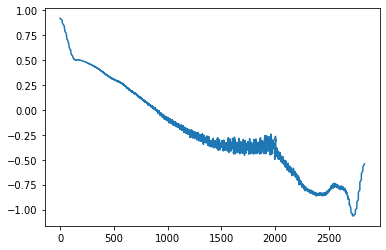

In [111]:
plt.plot(A.R, savgol_filter(A.C, 101, 3))

In [62]:
l = np.array(range(0, 2000, 150))
A = {}
for i in l:
    imgDir = r'I:\Data\Wei\01\%5d.tif' % i
    img = io.imread(imgDir)
    X, Y, I = divide_windows(img, windowsize=[40, 40], step=20)
    C = corrI(X, Y, I)
    A[str(i)] = distance_corr(X, Y, C)

In [21]:
# Set pyplot parameters
plt.rc('axes', lw=1.5)
font = {'family' : 'Sans',
        'size'   : 20}
plt.rcParams['font.size'] = 15

In [37]:
MPP = 0.33
FPS = 30

In [5]:
plt.figure(figsize=(10, 10))
for kw in A:
    plt.plot(A[kw].R*MPP, savgol_filter(A[kw].C, 101, 3), label=kw)
plt.axis([0, 330, -.5, 1])
plt.legend()


NameError: name 'A' is not defined

<Figure size 720x720 with 0 Axes>

<IPython.core.display.Javascript object>


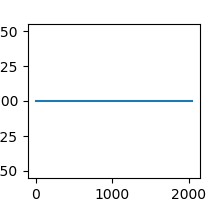

In [11]:
%matplotlib nbagg
plt.plot(X[0, :], Y[0, :])

In [50]:
plt.figure(figsize=(10, 10))
C = []
for kw in A:
    a = A[kw].loc[(A['50'].R>150)&(A['50'].R<155)].C.iloc[0]
    C.append(a)
plt.plot(l, C)

KeyError: '50'

<Figure size 720x720 with 0 Axes>

In [123]:
A['50'].loc[(A['50'].R>150)&(A['50'].R<155)]

,R,C
310,152.315462,0.586998
710,152.315462,0.581775


In [42]:
l = np.array(l)

In [ ]:
# Correlation length vs. time(s)

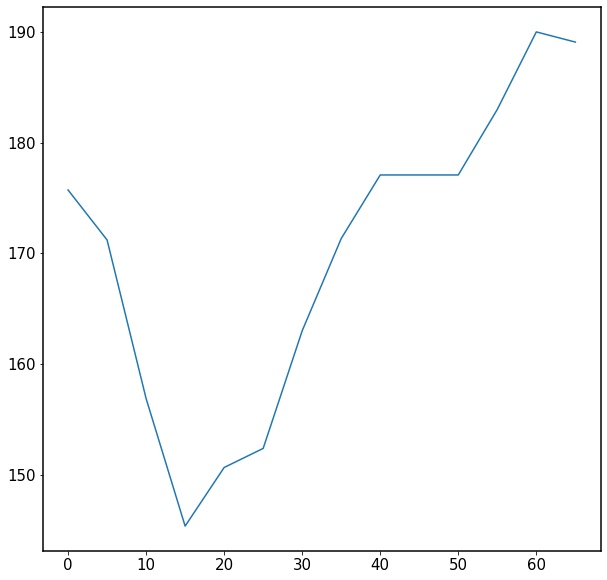

In [66]:
plt.figure(figsize=(10, 10))
C = []
for kw in A:
    a = A[kw].loc[(A[kw].C>0.25)&(A[kw].C<0.3)].R.iloc[0]
    C.append(a)
plt.plot(l / FPS, np.array(C) * MPP)

In [70]:
l = np.array(range(0, 2000, 10))
c = []
for i in l:
    imgDir = r'I:\Data\Wei\03\%5d.tif' % i
    img = io.imread(imgDir)
    X, Y, I = divide_windows(img, windowsize=[40, 40], step=20)
    contrast = I.std()/I.mean()
    c.append(contrast)


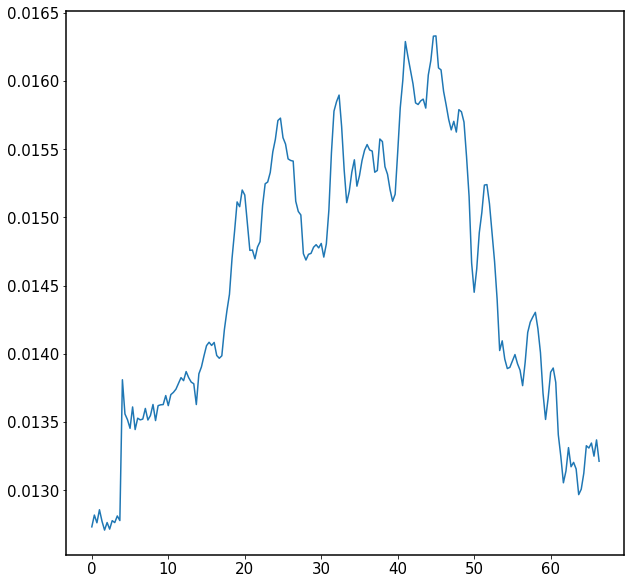

In [71]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(l/FPS, c)

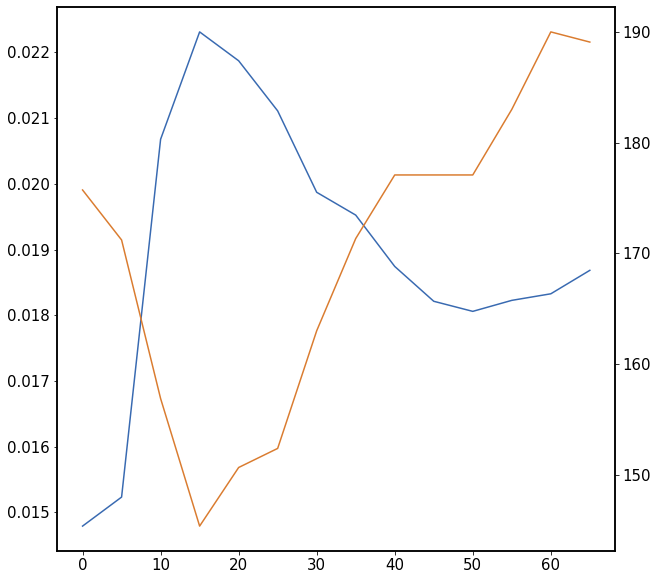

In [67]:
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.plot(l/FPS, c, color=bestcolor(0))
ax2 = ax1.twinx()
plt.plot(l/FPS, np.array(C) * MPP, color=bestcolor(1))

In [2]:
data = pd.read_csv(r'I:/Data/Wei/transient/00/Icorrdata.dat')

In [10]:
data1 = pd.read_csv(r'I:/Data/Wei/transient/01/Icorrdata.dat')
data2 = pd.read_csv(r'I:/Data/Wei/transient/02/Icorrdata.dat')
data3 = pd.read_csv(r'I:/Data/Wei/transient/03/Icorrdata.dat')

In [12]:
data = data.sort_values(by='R')
data1 = data1.sort_values(by='R')
data2 = data2.sort_values(by='R')
data3 = data3.sort_values(by='R')

[0, 800, -0.2, 1]

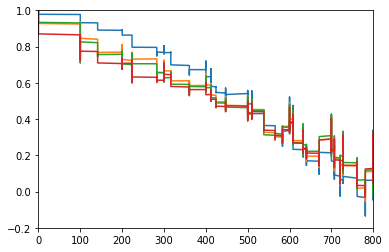

In [17]:
plt.plot(data.R, savgol_filter(data.C, 101, 3))
plt.plot(data1.R, savgol_filter(data1.C, 101, 3))
plt.plot(data2.R, savgol_filter(data2.C, 101, 3))
plt.plot(data3.R, savgol_filter(data3.C, 101, 3))
plt.axis([0, 800, -.2, 1])

In [19]:
frame = 0
data = {}
for i in range(0, 4):
    datapath = r'I:/Data/Wei/transient/%02d/Icorrdata.dat' % i
    data[str(i)] = pd.read_csv(datapath)

### Different density first frame

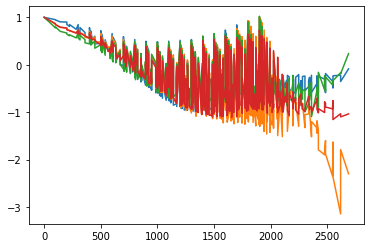

In [20]:
for kw in data:
    subdata = data[kw].loc[data[kw].frame==frame]
    subdata = subdata.sort_values(by='R')
    plt.plot(subdata.R, savgol_filter(subdata.C, 101, 3))

### Same density different time

[0, 1000, -0.5, 1]

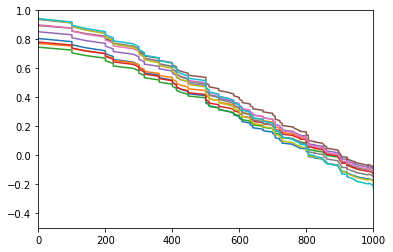

In [35]:
# data 0, 40 n0
tt = np.linspace(0, 1999, 10)
for t in tt:
    subdata = data['2'].loc[data['2'].frame==int(t)]
    subdata = subdata.sort_values(by='R')
    plt.plot(subdata.R, savgol_filter(subdata.C, 101, 3))
plt.axis([0, 1000, -.5, 1])

In [26]:
tt

array([   0.        ,  222.22222222,  444.44444444,  666.66666667,
        888.88888889, 1111.11111111, 1333.33333333, 1555.55555556,
       1777.77777778, 2000.        ])

In [2]:
imgDir = r'I:\Google Drive\Research projects\DF\nolight-light\0100.tif'
img = io.imread(imgDir)
X, Y, I = divide_windows(img, windowsize=[5.2, 5.2], step=5.2)

In [14]:
w = [5.2, 1.2]

In [15]:
w[0] = int(w[0])

In [4]:
0.33*1280/576

0.7333333333333334